# Tuberculosis Detection using Chest X-ray with CNNs, Lung Segmentation + LIME (0.99 accuracy)

# Outlines
- 1. Data Preprocessing
    - 1.1 Data Transforming
    - 1.2 Target
    - 1.3 Data Augmentation (Class imbalance problem) (Optional)
    - 1.4 Data Preparation
    - 1.5 Image Enhancement
        - 1.5.1 Contrast Stretching
        - 1.5.2 Histogram Equalization
        - 1.5.3 Adaptive Histogram Equalization
        - 1.5.4 Summary of each image enhancement

2. CNN:
    - 2.1 How CNNs Work
    - 2.2 Layers
        - 2.2.1 Convolutional Layers
        - 2.2.2 Pooling Layers
        - 2.2.3 Dropout Layer
        - 2.2.4 Flatten Layer
        - 2.2.5 Fully Connected (Dense) Layers
        - 2.2.6 Output Layers
    - 2.3 Hyperparameters in both convolutional and pooling layers
        - 2.3.1 Padding
        - 2.3.2 Kernel size
        - 2.3.3 Stride
    - 2.4 Activation Functions
        - 2.4.1 ReLU Activation function
        - 2.4.2 Sigmoid Activation function

3. Splitting the Dataset
    80:10:10
4. Modeling

5. Evaluation
    - 5.1 Training set Performance
    - 5.2 Test set Performance
    - 5.3 Confusion matrix
    - 5.4 ROC

6. Different Image Input Sizes

7. Model Prediction

8. Lung segmentation

9. Explainability
    - 9.1 Lime Library

# Problem Statment
Tuberculosis (TB) remains a significant global health issue, affecting millions of people worldwide. Timely and accurate diagnosis is crucial for effective management and control of the disease. Chest X-ray (CXR) imaging is a common diagnostic tool for TB, providing detailed insights into the condition of the lungs. Convolutional Neural Networks (CNNs) have demonstrated remarkable capabilities in image classification tasks, making them a promising technology for automated TB detection.

# Problem in dataset
The dataset consists of:
- Amount: 700 Tuberculosis images /  3500 normal images. (Class imbalance)
- File type .PNG
- Image size: 512x512 
- Channel: 3 channel (RGB )

In [ ]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

### View the variables 
<u>Read</u> 5 Training examples, And <u>check</u> the dimensions of raw data

In [ ]:
# range(start, stop, step)
for i in range(1,5):
    image = Image.open(
        f'../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-{i}.png')
    print(image.mode)
    print(image.size)
    plt.imshow(image)
    plt.show()

# 1. Data Preprocessing

 ## 1.1 Data Transforming
 Objective: (Tabulating) Converting **Image.PNG** Files to **NumPy Arrays**
 - **Pros:**
    - **Memory Efficiency:** NumPy arrays require less memory than raw image files, making it ideal for large datasets.
    - **Computational Efficiency:** NumPy array operations are optimized and faster.
    
- **Cons:**
    - **Lossy Compression:** Depending on the image format and compression settings used, converting images to NumPy arrays may involve lossy compression, which can result in some loss of image quality.
    - **Storage and Disk Space**: While NumPy arrays can be more memory-efficient, they can still consume a significant amount of disk space, especially for high-resolution images or a large number of images.

In [ ]:
import numpy as np
from numpy import asarray
import os
from tqdm import tqdm

In [ ]:
dir_path = '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/'

In [ ]:
def numpize(subset: str, img_size=(128, 128), grayscale=False):
    """
    Convert a set of images from a specified subset to NumPy arrays.

    Parameters:
    - subset (str): Specifies the subset of images, e.g., 'Normal' or 'Tuberculosis'.
    - img_size (tuple): Tuple representing the desired size of the images after resizing.
    - grayscale (bool): If True, convert images to grayscale.

    Returns:
    - numpy_array (numpy.ndarray): NumPy array containing the transformed images.
    """
    image_dir = f'{dir_path}/{subset}/'
    image_files = os.listdir(image_dir)
    image_count = len(image_files)
    transformed_images = []

    for i in tqdm(range(1, image_count + 1), desc='Transforming...'):
        image_path = f'{image_dir}/{subset}-{i}.png'
        image = Image.open(image_path)

        # Ensure all images are in the same format
        if grayscale:
            image = image.convert('L')  # Convert to grayscale
        else:
            image = image.convert('RGB')  # Convert to RGB

        # Resize all images to the specified size without padding
        resized_image = image.resize(img_size)
        data = np.asarray(resized_image)
        transformed_images.append(data)

    numpy_array = np.array(transformed_images)
    return numpy_array

## Normal

In [ ]:
norm = numpize(subset='Normal', 
               img_size=(128, 128), 
               grayscale=False)
norm.shape

## Tuberculosis

In [ ]:
tb = numpize(subset='Tuberculosis', 
             img_size=(128, 128), 
             grayscale=False)
tb.shape

## 1.2 Target

In [ ]:
target_norm = np.zeros(norm.shape[0])
print(f'Shape: {target_norm.shape[0]}, array: {target_norm}')

In [ ]:
target_tb = np.ones(tb.shape[0])
print(f'Shape: {target_tb.shape[0]}, array: {target_tb}')

In [ ]:
def show_image(images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False):
    '''
    :Parameters
        images (ndarray (n,)): Input data as a numpy array.
        target (ndarray (n,)): Target data as a numpy array.
        title (String): Title of the plot.
        num_display (int): Number of images to display. Default is 16.
        num_cols (int): Number of columns in the plot. Default is 4.
        cmap (str): Color map for displaying images. Default is 'gray'.
        random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
    '''
    # Determine the number of rows based on the num_cols parameter
    n_cols = min(num_cols, num_display)
    n_rows = int(np.ceil(num_display / n_cols))

    n_images = min(num_display, len(images))
    if random_mode:
        random_indices = np.random.choice(
            len(images), num_display, replace=False)
    else:
        random_indices = np.arange(num_display)

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i >= n_images:  # Check if the index exceeds the available number of images
            break
        # Incase (Did PCA)
        index = random_indices[i]
        if len(images.shape) == 2:
            image = images[index].reshape((128, 128)).astype(int)
        else:
            image = images[index]

        ax.imshow(image, cmap=cmap)
        ax.set_title("Target: {}".format(target[index]))

        # Add image index as text
        ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                fontsize=10, ha='center')

    plt.suptitle(f"{title} (Displaying {num_display} Images)",
                 fontsize=16, fontweight='bold')

    fig.set_facecolor('white')
    plt.tight_layout() 
    return plt.show()

In [ ]:
show_image(images=norm, 
           target=target_norm,
           title='Sample of Normal images',
           num_display=16, 
           num_cols=4, 
           cmap='gray', 
           random_mode=True)

In [ ]:
show_image(images=tb, 
           target=target_tb,
           title='Sample of Tuberculosis images',
           num_display=16, 
           num_cols=4, 
           cmap='gray', 
           random_mode=True)

In [ ]:
from skimage import img_as_float
from skimage import exposure

In [ ]:
def plot_gray_scale_histogram(images, titles, bins=100):
    '''
    Plot Gray Scale Histograms of Images.

    Parameters:
        - images (list): List of grayscale images to plot histograms for.
        - titles (list): List of titles for each histogram.
        - bins (int, optional): Number of bins for the histogram. Default is 100.

    Returns:
        None

    This function generates histograms for a list of grayscale images and displays them side by side. Each histogram is accompanied by its respective title.

    The function does not return any values; it displays the histogram plots directly.
    '''
    # Display results
    fig, axes = plt.subplots(2, len(images), figsize=(20, 8))

    for i, (title, image) in enumerate(zip(titles, images)):
        ax_img, ax_hist, ax_cdf, random_index = img_and_hist(
            image, axes[:, i], bins)

        mean_value = np.mean(image)
        std_value = np.std(image)
        min_value = np.min(image)
        max_value = np.max(image)

        ax_img.set_title('Random image of '+r'$\bf{' + f'{title}'+'}$' +
                         f'\nMean: {mean_value: .2f}, Std: {std_value: .2f}, Min: {min_value: .2f}, Max: {max_value: .2f}', fontsize=16)
        ax_img.text(0.5, -0.15, f'Image Index: {random_index}\n(Display random image)', transform=ax_img.transAxes,
                    fontsize=10, ha='center')

        y_min, y_max = ax_hist.get_ylim()
        ax_hist.set_title(
            'Distribution of pixel intensities of'+r'$\bf{' + f'{title}'+'}$', fontsize=16)
        ax_hist.set_ylabel('Number of pixels')
        ax_hist.set_yticks(np.linspace(0, y_max, 5))

        ax_cdf.set_ylabel('Fraction of total intensity')
        ax_cdf.set_yticks(np.linspace(0, 1, 5))

    plt.suptitle('Gray scale Histogram: Distribution of intensity pixel',
                 fontsize=16, fontweight='bold')
    # Prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()


def img_and_hist(image_data, axes, bins=100):
    '''
    Plot an image along with its histogram and cumulative histogram.

    Parameters:
        - image_data (ndarray): Grayscale image data as a numpy array.
        - axes (list): List of axes for displaying the image, histogram, and cumulative histogram.
        - bins (int): Number of bins for the histogram.

    Returns:
        - ax_img, ax_hist, ax_cdf: Axes objects for image, histogram, and cumulative histogram.

    This function displays an image along with its histogram and cumulative histogram. It takes the grayscale image data, a list of axes for plotting, and the number of bins for the histogram.

    The function returns the axes objects for the image, histogram, and cumulative histogram.
    '''

    '''
    Plot an image along with its histogram and cumulative histogram.
    '''
    image = img_as_float(image_data)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    random_index = np.random.randint(0, len(image_data))

    # Display image
    ax_img.imshow(image if image.shape[0] ==1 else image[random_index], cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    # ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf, random_index

In [ ]:
images = [norm, tb]
subsets = ['X_{Normal}', 'X_{Tuberculosis}']
# For visualization
plot_gray_scale_histogram(images=images, titles=subsets, bins=555)


**Explaination:**
- **Pixel Intensity** 0 (completely black) to 255 (completely white)
- **X-axis** (Pixel intensity) represents the entire dataset's darkness (closer to 0) to brightness (closer to 255).
- **Slope Red line** refer to brighter or darker of all dataset
    - Right-Skewed Distribution, mean pixel intensity is higher, indicating brighter areas.
    - Left-Skewed Distribution, mean pixel intensity is lower, signifying darker areas.
So, 
- **X_{Tuberulosis}** have a brighter or whiter areas
- **X_{Normal}** have a darker areas 

## 1.3 Data Augmentation (Class imbalance problem) (Optional):
Perform data augmentation techniques such as rotation, scaling, flipping, and adding noise to increase the diversity and size of your training dataset. This helps in improving the model's generalization ability.
### Objective
- solve class imbalance problem (700 TB images and 3500 normal images)

### Not Recommended:

1. **Reflection:**
    - Reflection in x-axis is discouraged due to potential confusion (e.g., 6 vs. 9).
    - Reflection in y-axis results in non-physiologic images, not recommended.
    - No method simulates differences between Posterior-Anterior (PA) and Anteroposterior (AP) chest X-rays.
2. **Severe Rotation:**
    - Avoid severe rotations (−90 to 90) as they may introduce unrealistic noise.
    - Slight rotations (−5 to 5) seen in practice can be helpful.
3. **Scaling:**
    - Large scaling (>×1) stretches the image, while small scaling (<×1) reduces its size.
    - Equal scaling in both axes is possible; scaling in only one axis is not recommended clinically.
4. **Shearing:**
    - Shearing is not recommended, producing clinically non-existent images.

### Could Be Helpful/Acceptable:

1. **Translation (Shifting):**
    - Shifting X-ray images can be useful to center lungs, enhancing detector robustness.
    - No clearly recommended translation range; considered acceptable clinically.

### Summary of Clinical Perspective
| Augmentation Technique | Recommendation | Explanation |
| --- | --- | --- |
| Reflection (x-axis) | Not Recommended | Adds unnecessary noise and misleads the learning algorithm. |
| Reflection (y-axis) | Not Recommended | Leads to non-physiologic images and confounds learning. |
| Rotation | Could be helpful (within -5 to 5 degrees) | Slight rotations seen in clinical practice, but severe rotations are not recommended. |
| Scaling | Not Recommended | Large scaling stretches the image, small scaling reduces size. Equal scaling is possible, but x-axis or y-axis scaling is not recommended clinically. |
| Shearing | Not Recommended | Produces images that do not exist clinically. |
| Translation | Could be helpful/acceptable | Shifting X-ray images can be useful for better lung positioning, but no recommended range. |
Read more: https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
def x_ray_image_augmentation(images, targets, sample_count):
    '''
    :Parameters
        df (ndarray (n,)): Input data as a numpy array.
        target (ndarray (n,)): Target data as a numpy array.
        sample_count (integer64): Number of data needed.
    '''

    # Randomize the data augmentation parameters
    rotation_range = random.randint(-5, 5)
    # width_shift_range = random.uniform(0.0, 0.05)      Not reccomend
    # height_shift_range = random.uniform(0.0, 0.05)     Not reccomend
    # shear_range = random.uniform(0.0, 0.1)             Not reccomend
    zoom_range = random.uniform(0.0, 0.1)
    fill_mode = random.choice(['nearest',
                               'constant',
                               #    'reflect',               Not reccomend
                               'wrap'])

    # Create the ImageDataGenerator with randomized parameters
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        # width_shift_range=width_shift_range,             Not reccomend
        # height_shift_range=height_shift_range,           Not reccomend
        # shear_range=shear_range,                         Not reccomend
        zoom_range=zoom_range,
        fill_mode=fill_mode
    )
    # Load and augment the data

    augmented_data_generator = datagen.flow(images, targets, batch_size=1)
    batch_images, batch_labels = augmented_data_generator.next()
    for _ in tqdm(range(sample_count), desc='augmenting...'):
        batch_images, batch_labels = augmented_data_generator.next()
        try:
            combined_images = np.concatenate(
                (combined_images, batch_images), axis=0)
            combined_labels = np.concatenate(
                (combined_labels, batch_labels), axis=0)
        except NameError:
            combined_images = np.concatenate((images, batch_images), axis=0)
            combined_labels = np.concatenate((targets, batch_labels), axis=0)
    '''
    Returns:
        combined_images (ndarray (n,)) : generated images
        combined_labels (ndarray (n,)) : generated labels
    '''

    return combined_images, combined_labels


In [ ]:
# Scaled the dataset before do Augmentation 
norm = norm/255
tb = tb/255

In [ ]:
show_image(images=tb,
           target=target_tb,
           title='After scaled Tuberculosis data', 
           num_display=16, 
           num_cols=8, 
           cmap='gray', 
           random_mode=False)

In [ ]:
tb_augmented, target_tb_augmented = x_ray_image_augmentation(images=tb, 
                                                             targets=target_tb, 
                                                             sample_count=2800)

In [ ]:
tb_augmented.shape

In [ ]:
print(
    f'Before {tb.shape[0]}\nAfter Data Augmentation {tb_augmented.shape[0]}\n+{tb_augmented.shape[0]-tb.shape[0]} Training examples')

In [ ]:
# Start index since 700 to last to observe to new training images
show_image(images=tb_augmented[700:-1],
           target=target_tb_augmented[700:-1],
           title='Augmented Tuberculosis data', 
           num_display=64, 
           num_cols=8, 
           cmap='gray', 
           random_mode=False)

### Compare Distribution (Tuberculosis Original Dataset vs Tuberculosis + Augmentation)

In [ ]:
images_2 = [tb, tb_augmented]
subsets_2 = ['X_{Tuberculosis}', 'X_{TuberculosisAugmentation}']
# For visualization
plot_gray_scale_histogram(images=images_2, titles=subsets_2, bins=555)

**Explanation**:

Both distributions are similar, as indicated by the red lines and statistical descriptors.

## 1.4 Data Preparation
prepare data to facilitate further processing and training. We will create explicit variables that are easy to call and work with.

- **X**; representing 7,000 samples, each with a size of 128x128 pixels. contains
    - 3500 samples will be the normal images 
    - 3500 samples will be the TB images 

- **y**; represents the binary classification labels, where 
    - 0 represents a normal image
    - 1 represents a TB image. 

In [ ]:
# Concatenate df_norm and df_tb along the first axis (samples)
X = np.concatenate((norm, tb_augmented), axis=0)

# Concatenate target_norm and target_tb
y = np.concatenate((target_norm,  target_tb_augmented), axis=0)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
import pandas as pd

In [ ]:
y_df = pd.DataFrame(y)
y_df.value_counts()

Balanced dataset!

## 1.5 Image Enhancement 
Image Pre-processing for Chest X-ray

<u>used</u> to improve their visual quality and enhance the details within the images.

Aim: 
- Improve the visibility of details in the image
- Enhance the contrast of the image

### 1.5.1 Contrast Stretching:
- Objective: Enhance the visibility of details and improve contrast in an image.
- Goal: Increase the dynamic range of pixel values by stretching the intensity values to a desired range.
- Pros:
    - Simple and easy to implement.
    - Enhances the contrast and visibility of details in an image.
- Cons:
    - It may not be effective for images with extremely low or high contrast.
    - It can amplify noise or artifacts in the image.

In [ ]:
from skimage import exposure

In [ ]:
def contrast_stretching(X):
    p2, p98 = np.percentile(X, (2, 98))
    stretched_img = exposure.rescale_intensity(X, in_range=(p2, p98))
    return stretched_img

In [ ]:
X_stretched = contrast_stretching(X[0:16])
show_image(images=X_stretched,
           target=y,
           title='Contrast Stretching images', 
           num_display=16, 
           num_cols=4, 
           cmap='gray', 
           random_mode=True)

### 1.5.2 Histogram Equalization:
- Objective: Enhance the global contrast and improve the overall brightness distribution in an image.
- Goal: Adjust the pixel intensity distribution to achieve a uniform histogram.
- Pros:
    - Effective in improving the global contrast of an image.
    - Enhances the visibility of details in both dark and bright regions.
- Cons:
    - May result in over-enhancement or unnatural appearance if applied to certain images.
    - Does not consider local image characteristics.

In [ ]:
def equalization(X):
    eq_img = exposure.equalize_hist(X)
    return eq_img

In [ ]:
X_eq = equalization(X[0:16])
show_image(images=X_eq,
           target=y,
           title='Histogram Equalization images', 
           num_display=16, 
           num_cols=4, 
           cmap='gray', 
           random_mode=True)

### 1.5.3 Adaptive Histogram Equalization:
- Objective: Enhance the contrast while preserving local details in an image.
- Goal: Apply histogram equalization locally to different regions of an image.
- Pros:
    - Enhances the contrast of images with varying local characteristics.
    - Preserves local details and avoids over-enhancement in homogeneous regions.
- Cons:
    - Can amplify noise or artifacts in regions with high frequency variations.
    - Requires additional computational resources compared to global histogram equalization.


Usage example: 
``` python
def adaptive_equalization(X, clip_limit):
    '''
    :Parameters:
    X (ndarray (n,)): Input data as a numpy array, X.shape should be (128, 128, 1)
    clip_limit (int or float): used to control the contrast
    '''
    # Normalize the input image to the range of -1 to 1 and perform adaptive histogram equalization
    X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
    X_normalized = (X_normalized * 2) - 1  # Scale to -1 to 1
    adapteq_img = exposure.equalize_adapthist(
        X_normalized, clip_limit=clip_limit)

    return adapteq_img

```

> Noted: I added '**batch_size**' parameter, Because of computational and memory constraints.

In [ ]:
def adaptive_equalization(X, clip_limit, batch_size=None):
    '''
    :Parameters:
    X (ndarray (n,)): Input data as a numpy array, X.shape should be (128, 128, 1)
    clip_limit (int or float): used to control the contrast     
    batch_size (int): Size of the batch to process. If None, the entire input is processed at once.
    '''
    if batch_size is None:
        # Normalize the input image to the range of -1 to 1 and perform adaptive histogram equalization
        X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
        X_normalized = (X_normalized * 2) - 1  # Scale to -1 to 1
        adapteq_img = exposure.equalize_adapthist(
            X_normalized, clip_limit=clip_limit)
    else:
        # Process data in batches
        num_batches = int(np.ceil(len(X) / batch_size))
        batch_results = []

        for i in tqdm(range(num_batches),desc='process...'):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X))

            # Normalize the input image to the range of -1 to 1 and perform adaptive histogram equalization for each batch
            X_normalized = (X[start_idx:end_idx] - np.min(X[start_idx:end_idx])) / \
                (np.max(X[start_idx:end_idx]) - np.min(X[start_idx:end_idx]))
            X_normalized = (X_normalized * 2) - 1  # Scale to -1 to 1
            adapteq_img_batch = exposure.equalize_adapthist(
                X_normalized, clip_limit=clip_limit)
            batch_results.append(adapteq_img_batch)

        # Concatenate the batch results
        adapteq_img = np.concatenate(batch_results, axis=0)

    return adapteq_img

In [ ]:
X_adapteq = adaptive_equalization(X[0:64],0.03)
show_image(images=X_adapteq,
            target=y,
            title='Adaptive Histogram Equalization', 
            num_display=16, 
            num_cols=4, 
            cmap='gray', 
            random_mode=True)

### 1.5.4 Summary of each image enhancement 

In [ ]:
sample = X[0,:,:,:]
sample.shape

In [ ]:
# 1. Load a normal image
img = sample

# 2. Contrast stretching
img_cs = contrast_stretching(img)

# 3. Histogram Equalization
img_eq = equalization(img)

# 4. Adaptive Equalization
img_adapteq = adaptive_equalization(img, 0.03)

methods = ['Low contrast image', 'Contrast stretching',
           'Histogram equalization', 'Adaptive equalization']
images_3 = [img, img_cs, img_eq, img_adapteq]

In [ ]:
def img_and_hist_single_img(image, axes, bins=100):
    '''
    Plot an image along with its histogram and cumulative histogram.
    '''
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    # ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [ ]:
# Display results
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i, (method, image) in enumerate(zip(methods, images_3)):
    ax_img, ax_hist, ax_cdf = img_and_hist_single_img(image, axes[:, i], bins=555)

    mean_value = np.mean(image)
    std_value = np.std(image)
    min_value = np.min(image)
    max_value = np.max(image)

    ax_img.set_title(
        r'$\bf{' + f'{method}'+'}$'+f'\nMean: {mean_value: .2f}, Std: {std_value: .2f}, Min: {min_value: .2f}, Max: {max_value: .2f}', fontsize=12)

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_title(
        'Distribution of pixel intensitie', fontsize=12, fontweight='bold')
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

plt.suptitle('Summary image enhancement techniques',
             fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

### Explanation

**Overview of plot**: aims to improve the contrast "Low contrast image."

**Red line**: (Black/White balances) A steeper curve indicates an increased Black/White intensity

| Method | Range | Pixel Intensity Distribution | Image | Conclusion | 
| --- | --- | --- | --- | --- |
| Low Contrast | [0, 255] | Original image | Original image | Original image |
| Contrast Stretching | [0, 1] | Similar distribution to original image | Similar to original image | Dataset normalized, Distribution similar to original image |
| Histogram Equalization | [0, 1] | New distribution | Similar to original image, But a little bit higher contrast |  Dataset normalized, Black/White is balanced |
| Adaptive Histogram Equalization | [0, 1] | New distribution | High contrast, Different local contrast in different regions of the image compared to the original image | Dataset normalized, Desirable contrast |

### How to consider 
<u>Answer</u> In fact we need to experiment <b>all image enhancement techniques</b> for Training in CNN, Which one give us a better Performance?


# 2. CNN:

## Deep Learning - Convolutional Neural Networks
Convolutional Neural Networks (CNNs) are a class of deep learning algorithms specifically designed for image processing, pattern recognition, and computer vision tasks. They have revolutionized the field of computer vision and have achieved state-of-the-art results in various image-related applications, such as object detection, image classification, segmentation, and more.

CNN are designed to perform tasks on the 2-D image, In the context of binary classification for TB detection, we can customize the output layer of the CNN to have a single unit, which will classify the input as either TB or normal.

![Alt Text](https://dwbi1.files.wordpress.com/2021/07/fig-1-cnn-architecture.jpg)

Image Source: https://dwbi1.wordpress.com/2021/07/04/what-is-convolutional-neural-network-cnn/

![Alt Text](https://www.mdpi.com/electronics/electronics-11-01775/article_deploy/html/images/electronics-11-01775-g001.png)
Image Source: https://www.mdpi.com/2079-9292/11/11/1775

### Why CNN?
CNNs are specifically suitable for image data:
- ANN (Artificial Neural Network) - Tabular data/ 1D -  used for tasks such as regression, binary classification, and multi-class classification on structured data
- RNN (Recurrent Neural Network) - Tabular data/ 1D (Time Series), designed for handling sequential data
- CNN (Convolutional Neural Network) - Image

### Use Cases 
#### ANN (Artificial Neural Network)

Data Type: Tabular data/1D
Typical Use Cases:

- Regression
- Binary Classification
- Multi-class Classification (structured data)

#### RNN (Recurrent Neural Network)

Data Type: Tabular data/1D (Time Series)
Typical Use Cases:

- Time Series Forecasting
- Natural Language Processing
- Speech Recognition

#### CNN (Convolutional Neural Network)

Data Type: Image
Typical Use Cases:

- Image Classification
- Object Detection
- Image Segmentation
- Image Generation

## 2.1 How CNNs Work:

Convolutional Neural Networks (CNNs) designed for image and visual data processing.

Training Process:
- Forward propagation
    - Receives the input images in a variable (say X) and applies a series of linear transformations through hidden layers using activation functions. until the **final output** layer produces predictions for the given input.
- Backward propagation
    - Randomly initialized the weights, biases and Adjust/Update parameters (weights and biases) during this step to minimize the Error/Loss function (**Gradient Optimization**) and improve the model's performance. 

CNNs Learning: Detecting Features in Images
- Convolutional Layers: ability to learn and detect the entire image and patterns, edges, and features. 
- Activation Functions: each layer applies an activation function, input images and calculated by activation function transform to the output of each layers.
- Pooling Layers: retain the most important information while reducing the computational complexity.

Summary using a Convolution or Pooling layer we reduce the dimensions of the input image of dimensions

Read more **Demystifying the Mathematics Behind Convolutional Neural Networks (CNNs)**: https://www.analyticsvidhya.com/blog/2020/02/mathematics-behind-convolutional-neural-network/

## 2.2 Layers

### 2.1.1 Convolutional Layers:
These layers perform the core operation in CNNs - convolution. Convolution involves sliding a set of small filters (also known as kernels) across the input image and computing dot products to create feature maps. Each filter specializes in detecting certain features like edges, corners, textures, etc.

For simplicity, let’s stick with grayscale images as we try to understand how CNNs work.


![image.png](https://editor.analyticsvidhya.com/uploads/750710_QS1ArBEUJjjySXhE.png)
Image Source: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/

 filter/kernel(3×3 matrix) and apply it to the input image to get the convolved feature. This convolved feature is passed on to the next layer.
 Each filter specializes in detecting certain features like edges, corners, textures, etc.


This layer learn to detect edges

![image-2.png](https://editor.analyticsvidhya.com/uploads/52794neural-networks-layers-visualization.jpg)

Image Source: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/

### 2.1.2 Pooling Layers:

![image.png](https://1299806939-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvMRntv-nKvtl7WOpCz%2F-LvMRp9FltcwEeVxPYFs%2F-LvMRrqrlhiBpH5LD-_p%2FPooling_Simple_max.png?generation=1575572710691611&alt=media)

Image Source: https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/pooling_layer


Pooling layers are **used to summarize the important features extracted from the previous convolutional layers. These layers reduce the spatial dimensions of the feature maps, typically reducing them by half.**

Pooling layers reduce the spatial dimensions of feature maps while <u>preserving</u> essential information. Each pooling region is transformed into a single output value, representing the presence of a particular feature in that region.

Objective: 
- Reduces the spatial dimensions of the feature maps, making the model more efficient and reducing overfitting.
- Maintaining essential information while improving computational efficiency.

Common pooling techniques are **max pooling**, which selects the maximum value in a local region, and **average pooling**

### 2.1.3 Dropout Layer
Random drop some Neural, 
Dropout is a regularization technique used to prevent overfitting in deep learning models. It involves randomly deactivating a fraction of neurons during training.
**Dropout**:  will prevent our network from overfitting thus helping our network generalize better. How much dropout should we add after each layer?
0%, 10%, 20%, 30%, 40%, 50%, 60%, or 70%

How it works:

Installing the dropout layer, a so-called dropout probability must also be specified. This determines how many of the nodes/units in the layer will be set equal to 0. If we have an input layer with ten input values, a dropout probability of 10% means that one random input will be set equal to zero in each training pass. If instead, it is a hidden layer, the same logic is applied to the hidden nodes/units. So a dropout probability of 10% means that 10% of the nodes/units will not be used in each run.

Dropout layer is often <u>used</u> after a **Fully Connected (Dense) Layers**
> Noted 1 **Dropout**:  will prevent our network from overfitting thus helping our network generalize better. How much dropout should we add after each layer?
0%, 10%, 20%, 30%, 40%, 50%, 60%, or 70%


### 2.1.4 Flatten Layer
The Flatten layer reshapes the output from previous layers into a 1D vector. It is used to convert the multidimensional feature maps into a flat feature vector so that it can be processed by fully connected layers.
**Enables the utilization of fully connected layers to make predictions or decisions based on the learned features.**

Pros:
- Enables the model to process the learned features from convolutional layers in fully connected layers.
- Simplifies the representation of data, making it easier for the subsequent layers to interpret and learn from the features.
- Allows the model to be compatible with architectures that require 1D inputs, such as traditional fully connected neural networks.
Cons:
- might losing some locality information.

### 2.1.5 Fully Connected (Dense) Layers
Fully connected layers consist of a fixed number of neurons connected to every neuron in the previous layer. They help combine learned features and make the final predictions. ReLU activation functions are commonly used for hidden layers, introducing non-linearity. For binary classification tasks like TB detection, a sigmoid activation function is used in the output layer to produce a probability score between 0 and 1 for classifying an image as TB or normal.
**Combining the learned features from previous layers and making final predictions in a neural network.**

### 2.1.6 Output Layers 
The Output Layer is the final layer of a neural network that produces the model's predictions. In binary classification tasks like Tuberculosis (TB) detection, the output layer typically consists of a single neuron with a sigmoid activation function.

Objective:
output layer is to generate a probability score between 0 and 1, representing the likelihood of the input belonging to a particular class. In TB detection, the output layer aims to classify the input chest X-ray image as either TB positive or normal based on the learned features from the previous layers.

Outcomes:
**a probability score close to 0 for normal images and close to 1 for TB images**, allowing the model to classify the input X-ray images accurately.
By applying an appropriate threshold to the output probability score, we can make the final decision on whether an X-ray image is classified as TB positive or normal.

## 2.3 Hyperparameters in both **convolutional** and **pooling** layers

### 2.3.1 Padding
Padding is the process of adding extra border pixels around the input image before applying convolutions.

**Purpose**:
- preserve the spatial dimensions of the feature maps, especially at the edges, which can be lost during convolutional operations.
- helps avoid the reduction in the feature map's size, which can occur when using a large kernel or multiple layers of convolutions.
- Padding involves adding zero-value pixels around the input image. This helps to <u>preserve</u> valuable information during convolution and ensures that the feature map doesn't become excessively small.

**Problem**: When Convolution → smaller output

**Solution**: +Padding

**When to use**: 

Try using padding = same when you feel the border’s of the image might be important, Because when Convolution → smaller output
**Type of Padding**:

![0rs9l.gif](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*jSYji1D43vJWZZ_5)

Image Source: https://sarathpanat.medium.com/all-about-convolutional-neural-network-cnn-6ccce6738958


1. Padding `'valid'` is the 1st figure.
    - means no padding at all. Just leave your data the same it was.    
2. Padding `'same'` is the 3rd figure.
    - The output is the same size. It is called SAME because for a convolution with a stride=1, (or for pooling) it should produce output of the same size as the input. 


### 2.3.2 Kernel size
refers small filter applied during the convolution operation.
Common kernel sizes are (3x3), (5x5), and (7x7), but other sizes

Purpose:
-  captures more contextual information

### 2.3.3 Stride 
skip scanning pixel
controls the step size of the filter as it scans the input image.
In both **convolutional** and **pooling** layers:
1. Convolutional Stride: A stride of 1 means the **filter** moves one **pixel** at a time
2. Pooling Stride: A stride of 1 means the **window** moves one **pixel** at a time




**Purpose**:
- faster computation and downsampling of the data.

**When to use**: 
- Stride = 1: Input data is small, and preserving spatial information is important.
- Stride > 1: Input data is large, help reduce computational cost and memory usage, But lead to **information loss**

![0_iqNdZWyNeCr5tCkc.gif](https://miro.medium.com/v2/resize:fit:640/format:webp/0*wW8SEzhhhTDN30Ow)

Image Source: https://sarathpanat.medium.com/all-about-convolutional-neural-network-cnn-6ccce6738958


> Noted 2 **Stride**: Stride just means the amount a filter moves during a covolution operation. So, a stride of 1 means that the filter will slide 1 pixel after each covolution operation as shown in this animation.


> Noted 3 **In practice**: Stride is often set based on experimentation and model performance on the validation set.

## 2.4 Activation Functions
### 2.4.1 ReLU Activation function 
The Rectified Linear Activation function (ReLU) is specifically used as a non-linear activation function, as opposed to other non-linear functions such as Sigmoid because it has been empirically observed that CNNs using ReLU are faster to train than their counterparts. ReLU is performed after every convolutional layer

The ReLU activation function is a one-to-one mathematical operation:
#### Why this Activations?  
Using non-linear activation functions like ReLU is crucial because real-world data and patterns are often complex and non-linear. If we only use linear activation functions, the neural network can only learn linear relationships, limiting its ability to capture more intricate patterns and reducing its performance. better performance in tasks like image classification, object detection, and more.

#### Output of this Activations?  
1. If the input is greater than or equal to zero, the output is equal to the input itself (Output = Input).
2. If the input is less than zero, the output is zero (Output = 0).

In mathematical terms, the ReLU function can be defined as follows:

$$ReLU(x) = max(0, x) \tag{1}$$



### 2.4.2 Sigmoid Activation function 
used in the output layer of neural networks for Binary classification tasks. The Sigmoid activation function is a non-linear activation commonly used in neural networks. It maps any input value to a range between 0 and 1, allowing it to interpret the input as probabilities.

The Sigmoid function can be written:
$$sigmoid(x) = \frac{1}{1+{e^{-x} }} \tag{2}$$
Where "x" is the input value, and "e" represents the exponential function.



#### Why this Activations?  
- <u>used</u> in the output layer of neural networks for binary classification tasks, where the goal is to classify data into two classes (e.g., yes or no, true or false). 
- <u>converts</u> the model's raw output into a probability value

#### Output of this Activations?  
- <u>transforms</u> input values into probabilities between 0 and 1, making it suitable for binary classification tasks that require a probability-based decision.

Table representing the architecture of the CNN model 

| Layer (Type)   | Number of Filters | Padding | Activation | Out of Activation Shape | Total Parameters            |
|-----------------|-------------------|---------|------------|--------------------------|-----------------------------|
| Input           | -                 | -       | -          | (128, 128, 1)            | 0                           |
| Conv2D          | 32 * unit_size_rate| Same    | ReLU       | (128, 128, 32)           | 320 * unit_size_rate        |
| MaxPooling2D    | -                 | Same    | -          | (64, 64, 32)             | 0                           |
| Conv2D          | 64 * unit_size_rate| Same    | ReLU       | (64, 64, 64)             | 18,496 * unit_size_rate     |
| MaxPooling2D    | -                 | Same    | -          | (32, 32, 64)             | 0                           |
| Conv2D          | 128 * unit_size_rate| Same    | ReLU       | (32, 32, 128)            | 73,856 * unit_size_rate     |
| MaxPooling2D    | -                 | Same    | -          | (16, 16, 128)            | 0                           |
| Flatten         | -                 | -       | -          | (32768)                  | 0                           |
| Dense           | 128 * unit_size_rate| -      | ReLU       | (128)                    | 4,194,560 * unit_size_rate |
| Dropout         | -                 | -       | -          | (128)                    | 0                           |
| Dense           | 1                 | -       | Sigmoid    | (1)                      | 129                         |

Total Params: 4,287,361 * unit_size_rate

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense

In [ ]:
class CNN:
    def __init__(self, 
                 input_shape=(128, 128, 3), 
                 unit_size_rate=0.05, 
                 conv_padding='same', 
                 conv_kernel_size=(3, 3),
                 conv_stride=1, 
                 pool_padding='same', 
                 pool_kernel_size=(2, 2), 
                 pool_stride=2, 
                 dropout=0, 
                 l1_lambda=None,
                 l2_lambda=None, 
                 pooling_type='max', 
                 epochs=5, 
                 batch_size=64, 
                 verbose=1):
        self.input_shape = input_shape
        self.unit_size_rate = unit_size_rate
        self.conv_padding = conv_padding
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.pool_padding = pool_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.dropout = dropout
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.pooling_type = pooling_type
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = self.build_model()

    def build_model(self):
        reg_l1 = None
        reg_l2 = None

        if self.l1_lambda is not None:
            reg_l1 = tf.keras.regularizers.l1(self.l1_lambda)

        if self.l2_lambda is not None:
            reg_l2 = tf.keras.regularizers.l2(self.l2_lambda)

        if len(self.input_shape) == 2:
            # Add color channel for grayscale images
            self.input_shape = self.input_shape + (1,)

        model = Sequential()
        model.add(Conv2D(
            int(32 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            activation='relu',
            kernel_regularizer=reg_l1,
            input_shape=self.input_shape))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Conv2D(
            int(64 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            kernel_regularizer=reg_l2,
            activation='relu'))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Conv2D(
            int(128 * self.unit_size_rate),
            self.conv_kernel_size,
            strides=self.conv_stride,
            padding=self.conv_padding,
            kernel_regularizer=reg_l2,
            activation='relu'))

        if self.pooling_type == 'max':
            model.add(MaxPooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        elif self.pooling_type == 'avg':
            model.add(AveragePooling2D(
                pool_size=self.pool_kernel_size,
                strides=self.pool_stride,
                padding=self.pool_padding))
        else:
            raise ValueError("Invalid pooling_type. Use 'max' or 'avg'.")

        model.add(Flatten())
        model.add(Dense(
            units=int(128 * self.unit_size_rate),
            activation='relu',
            kernel_regularizer=reg_l2))

        model.add(Dropout(self.dropout))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def predict(self, X, threshold=0.5, verbose=0):
        return (self.model.predict(X, verbose=verbose) > threshold).astype("int32")

    def summary(self):
        self.model.summary()

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, verbose=1):
        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size if batch_size else self.batch_size,
            epochs=epochs if epochs else self.epochs,
            verbose=verbose,
            validation_data=(X_val, y_val)
        )
        return history

In [ ]:
cnn = CNN(unit_size_rate=1,
          input_shape=(128,128,3))

In [ ]:
cnn.summary()

# 3. Splitting the Dataset:
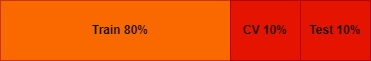

Split the dataset into training, validation, and test sets. The usual split ratios are 
- 80% for training, 
- 10% for validation, 
- and 10% for testing. 
Ensure that the classes are balanced in each split.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def viz_class_distribution(X, y, title, classe_labels, train_percent=0.6, val_percent=0.2, test_percent=0.2):
    '''
    :Parameters:
    - X (numpy array): The input feature matrix of shape (num_examples, num_features).
    - y (numpy array): The target labels of shape (num_examples,).
    - title (str): The title for the entire plot.
    - classes (list): A list of class labels, e.g., ['Normal', 'Tuberculosis'].
    - train_percent (float): Percentage of data for training set.
    - val_percent (float): Percentage of data for validation set.
    - test_percent (float): Percentage of data for test set.

    :Returns:
    - X_train, y_train, X_test, y_test, X_val, y_val: The subsets of the data.
    '''
    assert train_percent + val_percent + test_percent == 1.0, "Sum of train_percent, val_percent, and test_percent should be 1.0"

    # Convert y to integers
    y = y.astype(int)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=val_percent + test_percent, random_state=42, stratify=y)

    test_size = test_percent / (val_percent + test_percent)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size, random_state=42, stratify=y_temp)

    # Create a subplot with 3 columns and 1 row
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # List of subset names
    subset_names = ['Train', 'Test', 'Validation']
    n = len(X)

    # Iterate over subsets
    for i, subset in enumerate([(X_train, y_train), (X_test, y_test), (X_val, y_val)]):
        X_subset, y_subset = subset
        n_subset = len(y_subset)
        # Get the class counts
        class_counts = np.bincount(y_subset)

        # Plot histogram for the current subset
        axs[i].bar(classe_labels, class_counts, color='#AA99FF')
        subtitle = r'$\bf{' + subset_names[i] + \
            '}$' + f' {int(n_subset/n*100)} %'
        axs[i].set_title(
            subtitle + f'\n Size = {X_subset.shape[0]}', fontsize=18)
        axs[i].set_xlabel('Class')
        axs[i].set_ylabel('Number of examples')

        # Add labels to the bars
        for j, count in enumerate(class_counts):
            axs[i].text(j, count, str(count), ha='center',
                        va='bottom', fontsize=12)

    class_counts = np.bincount(y)
    class_balance_text = ' | '.join(
        [f'{class_label} ({count})' for class_label, count in zip(classe_labels, class_counts)])
    plt.suptitle(f'{title}' + f'\n Training examples (X): {X.shape[0]}' +
                 f'\nTarget (y): {class_balance_text}', fontsize=20)

    plt.tight_layout()
    plt.show()

    return X_train, y_train, X_test, y_test, X_val, y_val

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = viz_class_distribution(X=X, 
                        y=y, 
                        title='Class Distribution of Splitting', 
                        classe_labels=['Normal', 'Tuberculosis'], 
                        train_percent=0.8, 
                        val_percent=0.1, 
                        test_percent=0.1)

In [ ]:
images = [X_train, X_test, X_val]
subsets = ['X_{train}', 'X_{test}', 'X_{val}']
# For visualization
plot_gray_scale_histogram(images=images, titles=subsets, bins=555)

# 4. Modeling

In [ ]:
model_config = {
    # (height, width, channels)
    'input_shape': (128, 128,3),
    'unit_size_rate': 0.05,
    'l1_lambda': None,
    'l2_lambda': None,

    'conv_padding': 'same',
    'conv_kernel_size': (3, 3),
    'conv_stride': 1,

    'pool_padding': 'same',
    'pool_kernel_size': (2, 2),
    'pool_stride': 2,
    
    'dropout': 0,
    'pooling_type': 'max'
}

# Build model
model_1st = CNN(**model_config).build_model()
model_1st.summary()

In [ ]:
import time

In [ ]:
optimizer = tf.keras.optimizers.Adam()
optimizer_config= optimizer.get_config()
optimizer_config

In [ ]:
start_time = time.time()
# verbose is progress bar; verbose = 1 display, verbose = don't display 
verbose = 1
# Compile the model
model_1st.compile(loss='binary_crossentropy',
                   optimizer=optimizer,
                   metrics='accuracy')

# Train the model
history = model_1st.fit(X_train, y_train, 
                             epochs=30,
                             batch_size=64,
                             validation_data=(X_val, y_val),
                             verbose=verbose)

end_time = time.time()
training_time = end_time - start_time
training_time

In [ ]:
print(f'Training time in minutes: {training_time/60:.2f} minutes')

In [ ]:
get_config = {
            'Optimizer parameters Configuration': {
                'optimizer_name': optimizer_config['name'],
                'learning_rate': optimizer_config['learning_rate'],
                'beta1': optimizer_config['beta_1'],
                'beta2': optimizer_config['beta_2'],
                'epsilon': optimizer_config['epsilon'],
            },
            'Hyperparameters Configuration': {
                'conv_padding': model_config['conv_padding'],
                'conv_kernel_size': model_config['conv_kernel_size'],
                'conv_stride': model_config['conv_stride'],
                'pool_padding': model_config['pool_padding'],
                'pool_kernel_size': model_config['pool_kernel_size'],
                'pool_stride': model_config['pool_stride'],
                'pooling_type': model_config['pooling_type'],
            },
            'Model Architecture Configuration': {
                'input_shape': model_config['input_shape'],
                'unit_size_rate': model_config['unit_size_rate']
            },
            'Model Training Configuration': {
                'batch_size': 20,
                'epoch': 64
            },
        }
get_config

In [ ]:
def get_history(history,
                model,
                training_time:float, 
                ref_name:str, 
                title:str):

        best_epoch = np.argmax(history.history['val_accuracy'])
        best_train_epoch = np.argmax(history.history['accuracy'])

        # Create a 1x2 grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(24, 15))

        # Plot training and validation accuracy
        axes[0].plot(history.epoch, history.history['accuracy'],
                     label='Train Accuracy')
        axes[0].plot(history.epoch, history.history['val_accuracy'],
                     label='Validation Accuracy')
        axes[0].scatter(best_epoch, history.history['val_accuracy']
                        [best_epoch], color='r', label='Best Epoch (Validation)')
        axes[0].scatter(best_train_epoch, history.history['accuracy']
                        [best_train_epoch], color='g', label='Best Epoch (Train)')

        # Annotate the best validation accuracy point
        best_accuracy = history.history['val_accuracy'][best_epoch]
        random_offset_x = 10
        random_offset_y = np.random.randint(-30, 30)
        axes[0].annotate(f'{best_accuracy:.3f}',
                         xy=(best_epoch, best_accuracy),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy (%)')
        axes[0].set_title('Training and Validation Accuracy')
        axes[0].legend()

        # Annotate the best training accuracy point
        best_train_accuracy = history.history['accuracy'][best_train_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[0].annotate(f'{best_train_accuracy:.3f}',
                         xy=(best_train_epoch, best_train_accuracy),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Plot training and validation loss
        axes[1].plot(history.epoch,
                    history.history['loss'], label='Train Loss')
        axes[1].plot(history.epoch, history.history['val_loss'],
                     label='Validation Loss')
        axes[1].scatter(best_epoch, history.history['val_loss']
                        [best_epoch], color='r', label='Best Epoch (Validation)')
        axes[1].scatter(best_train_epoch,history.history['loss']
                        [best_train_epoch], color='g', label='Best Epoch (Train)')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Training and Validation Loss')
        axes[1].legend()

        # Annotate the best validation loss point
        best_loss = history.history['val_loss'][best_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[1].annotate(f'{best_loss:.3f}',
                         xy=(best_epoch, best_loss),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Annotate the best training loss point
        best_train_loss = history.history['loss'][best_train_epoch]
        random_offset_y = np.random.randint(-30, 30)
        axes[1].annotate(f'{best_train_loss:.3f}',
                         xy=(best_train_epoch, best_train_loss),
                         xytext=(random_offset_x, random_offset_y),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle='->'))

        # Calculate best validation accuracy in percentage
        best_accuracy_percentage = round(best_accuracy * 100, 2)

        # String for performance, accuracy, and training time
        minutes = int(training_time // 60)
        seconds = int(training_time % 60)

        # model summary
        stringlist = []
        model.summary(print_fn=lambda x: stringlist.append(x))
        short_model_summary = "\n".join(stringlist)

        # Set the text for the parameters on the right side
        performance = r'$\bf{' + f'Ref. name: {ref_name}' + '}$' + f"\nBest Validation Accuracy: {best_accuracy_percentage}%" + \
            f"\nBest Train Accuracy: {history.history['accuracy'][best_train_epoch] * 100:.2f}%" + \
            f", Training Time: {minutes} minutes {seconds} seconds"
        fig.suptitle(r'$\bf{' + title + '}$' +
                     '\n' + performance, fontsize=18)

        fig.text(1.05, 1.00, r'$\bf{' + 'Config Parameters:' + '}$', fontsize=16,
                 color='black', ha='left', transform=plt.gcf().transFigure)

        y_coord = 0.98  # Initial y-coordinate

        # Set the line height between each parameter group and each parameter within a group
        line_height = 0.028

        for group, params in get_config.items():
            fig.text(1.05, y_coord, r'$\bf{' + f'{group}:' + '}$', fontsize=14,
                     color='black', ha='left', transform=plt.gcf().transFigure)
            y_coord -= line_height

            for key, value in params.items():
                fig.text(1.05, y_coord, f"{key}: {value}", fontsize=12,
                         color='black', ha='left', transform=plt.gcf().transFigure)
                y_coord -= line_height

        fig.text(1.05, 0.01, r'$\bf{' + f'Model Summary:' + '}$' + f'\n{short_model_summary}',
                 fontsize=10, color='black', ha='left', transform=plt.gcf().transFigure)

        plt.tight_layout()
        plt.show()

In [ ]:
title = 'Experiment 1: Build 1st CNNs model'
get_history(history=history,
            model=model_1st,
            training_time=training_time, 
            title=title, 
            ref_name='Original Dataset')

# 5. Evaluation

In [ ]:
import json
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, f1_score

In [ ]:
 def evaluate(estimator_name, estimator, X, y_actual, subset_name, training_time, threshold=None):

        # Model Prediction/Y hat
        y_pred = estimator.predict(
            X) 
        # Handling Output Layer of Activation='sigmoid'
        threshold = threshold if threshold else 0.5
        y_pred_binary = (y_pred > threshold).astype(int).flatten()

        # Calculate ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_actual, y_pred_binary)
        auc_score = roc_auc_score(y_actual, y_pred_binary)
        # Classification Report
        report = classification_report(
            y_actual, y_pred_binary, output_dict=True)
        report_dict = json.loads(json.dumps(report))

        # Extract precision and recall from report_dict
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        accuracy = report_dict['accuracy']
        f1 = report_dict['weighted avg']['f1-score']

        # Confusion Matrix
        cm = confusion_matrix(y_actual, y_pred_binary)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        total_seconds = training_time
        minutes = int(training_time // 60)
        seconds = int(training_time % 60)
        training_time_ = "{} minutes {} seconds".format(minutes, seconds)

        accuracy_train = history.history['accuracy']
        accuracy_val = history.history['val_accuracy']

        performance_info = {
            'Model': estimator_name,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'Subset': subset_name,
            'Training time': training_time_,
            'Training in seconds': total_seconds,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC': auc_score,
            'Accuracy': accuracy,
        }
        return pd.DataFrame([performance_info])

## 5.1 Training set Performance 

In [ ]:
evaluate(estimator_name='CNN', 
         estimator=model_1st, 
         X=X_train, 
         y_actual=y_train, 
         subset_name='Training', 
         training_time=training_time
         )

## 5.2 Test set Performance 

In [ ]:
evaluate(estimator_name='CNN', 
         estimator=model_1st, 
         X=X_test, 
         y_actual=y_test, 
         subset_name='Test', 
         training_time=training_time
         )

In [ ]:
def plot_confusion_matrix(y_actual, y_pred, subset_name):
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_actual, y_pred_binary)
    labels = ['Negative', 'Positive']

    # Extract TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Sensitivity or True Positive Rate
    specificity = tn / (tn + fp)  # Specificity or True Negative Rate

    plt.figure(figsize=(18, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)



    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {subset_name}\n'
              f'True Positives: {tp} | True Negatives: {tn}\n'
              f'False Positives: {fp} (Type I error) | False Negatives: {fn} (Type II error)\n'
              f'Sensitivity (True Positive Rate): {sensitivity:.4f} | Specificity (True Negative Rate): {specificity:.4f}',
              loc='center', wrap=True)
    plt.show()

In [ ]:
y_pred_test = model_1st.predict(X_test)

## 5.3 Confusion matrix

In [ ]:
plot_confusion_matrix(y_actual=y_test, 
                      y_pred=y_pred_test, 
                      subset_name='Test')

## 5.4 ROC

In [ ]:
def plot_roc(y_actual, y_pred, subset_name):
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    # Print ROC Curve
    plt.figure(figsize=(18, 9))
    plt.plot(fpr, tpr, marker='o', linestyle='-',)
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.title(f'ROC Curve - {subset_name}')
    plt.grid()
    plt.show()

In [ ]:
plot_roc(y_actual=y_test, y_pred=y_pred_test, subset_name='Test')

# 6. Different Image Input Sizes
## **Expected Outcome:**

We expect that resizing the images to 128x128 might lead to a slight decrease in accuracy compared to using the original 512x512 images. However, the reduced image size may offer faster training and inference times, making it a more practical choice for resource-constrained environments. The experimental results will provide insights into the trade-offs between model accuracy and computational efficiency when dealing with different image sizes in TB detection using CNNs.

In [ ]:
target_shapes = [(16, 16),(32, 32), (64, 64), (128, 128)]
for target_shape in target_shapes:
    X_resized = tf.image.resize(X, target_shape).numpy()
    model_config = {
        # (height, width, channels)
        'input_shape': target_shape +(3,),
        'unit_size_rate': 0.05,
        'l1_lambda': None,
        'l2_lambda': None,

        'conv_padding': 'same',
        'conv_kernel_size': (3, 3),
        'conv_stride': 1,

        'pool_padding': 'same',
        'pool_kernel_size': (2, 2),
        'pool_stride': 2,

        'dropout': 0,
        'pooling_type': 'max'
    }

    # Build model
    model = CNN(**model_config)

    X_train, X_temp, y_train, y_temp = train_test_split(
    X_resized, y, test_size=0.2, random_state=42, stratify=y)

    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    # Train the model
    start_time = time.time()

    history = model.train(X_train, y_train, X_val, y_val,
                                 epochs=5,
                                 batch_size=64,
                                 verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    mean_acc = np.mean(history.history['val_accuracy'])
    show_image(images=X_resized, target=y,
               title=f'Resize the input images {target_shape}\nAvg. accuracy = {mean_acc:2f}\nTraining time: {training_time/60:.2f} minutes', 
               num_display=4, 
               num_cols=4, 
               random_mode=False)

# 7. Model Prediction

In [ ]:
def compare_actual_and_predicted_xray(estimator, images, target, title, num_display=16, num_cols=4, random_mode=False):
    '''
    Compare Actual X-ray Images with Model Predictions.

    Parameters:
        estimator: Model used for predictions.
        images (ndarray): Input data as a numpy array.
        target (ndarray): Target data as a numpy array.
        title (str): Title of the plot.
        num_display (int, optional): Number of images to display. Default is 16.
        num_cols (int, optional): Number of columns in the plot. Default is 4.
        random_mode (bool, optional): If True, display images randomly. If False, display the first num_display images. Default is False.

    Returns:
        None

    This function generates a visual comparison between actual X-ray images and their corresponding model predictions. It displays a grid of images with labels to show whether the model's predictions match the actual target values. The grid is organized in rows and columns based on the specified parameters.

    The function does not return any values; it displays the comparison plot directly.
    '''

    n_cols = min(num_cols, num_display)
    n_rows = int(np.ceil(num_display / n_cols))

    title = r'$\bf{' + "Actual-Image" + '}$' + " vs " + \
        r'$\bf{' + "Model-Prediction" + '}$'
    y_hat = estimator.predict(images)
    prediction = (y_hat > 0.5).astype(int).flatten()

    n_images = min(num_display, len(images))
    if random_mode:
        random_indices = np.random.choice(
            len(images), num_display, replace=False)
    else:
        random_indices = np.arange(num_display)

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i >= n_images:  # Check if the index exceeds the available number of images
            break
        # Incase (Did PCA)
        index = random_indices[i]
        if len(images.shape) == 2:
            image = images[index].reshape((128, 128)).astype(int)
        else:
            image = images[index]
        actual_label = target[index]
        model_pred_label = prediction[index]
        model_prob = '{:.3f}'.format(float(y_hat[index]))
        ax.imshow(
            image, cmap='gray' if actual_label == model_pred_label else 'OrRd')
        ax.set_title(
            f"Actual: {actual_label},\nModel Prediction: {model_pred_label}\nProbability: {model_prob}")
    plt.suptitle(f"{title} (Displaying {num_display} Images)",
                 fontsize=16, fontweight='bold')

    fig.set_facecolor('white')
    plt.tight_layout()  
    plt.show()

In [ ]:
compare_actual_and_predicted_xray(
                estimator=model_1st,
                images=X_test,
                target=y_test, 
                title=None,
                num_display=100,
                num_cols=10, 
                random_mode=True)

# 8. Lung segmentation
**Objective**: adapt this Lung segmentation for LIME
steps:
- Equalize the image with CLAHE
- Create a threshold mask to separate tissue by pixel intensity
- Find regions in the threshold
- Remove borders
- Fill small holes
- Extract lung areas

**Reference**: Lung Segmentation without CNN->https://www.kaggle.com/code/davidbroberts/lung-segmentation-without-cnn/notebook


In [ ]:
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

In [ ]:
class ImageSegmentation:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def lung_segmentation(self, X):
        if X.shape != self.input_shape:
            X = X[:, :, 0]

        # Equalize the image with CLAHE
        X = exposure.equalize_adapthist(
            X, kernel_size=None, clip_limit=0.01, nbins=256)

        # Create a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X, nbins=256, hist=None)
        thresh = X > thresh
        bw = closing(X > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        image_label_overlay = label2rgb(
            label_image,
            image=X,
            bg_label=0,
            bg_color=(0, 0, 0))

        return image_label_overlay, label_image

    def show_segmented_images(self,images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False,only_segmented=True):
        '''
        :Parameters
            images (ndarray (n,)): Input data as a numpy array.
            target (ndarray (n,)): Target data as a numpy array.
            title (String): Title of the plot.
            num_display (int): Number of images to display. Default is 16.
            num_cols (int): Number of columns in the plot. Default is 4.
            cmap (str): Color map for displaying images. Default is 'gray'.
            random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
        '''
        # Determine the number of rows based on the num_cols parameter
        n_cols = min(num_cols, num_display)
        n_rows = int(np.ceil(num_display / n_cols))

        n_images = min(num_display, len(images))
        if random_mode:
            random_indices = np.random.choice(
                len(images), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        fig, axes = plt.subplots(
            nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
        for i, ax in enumerate(axes.flatten()):
            if i >= n_images:  # Check if the index exceeds the available number of images
                break
            # Incase (Did PCA)
            index = random_indices[i]
            if len(images.shape) == 2:
                image = images[index].reshape((128, 128)).astype(int)
            else:
                image = images[index]

            image_label_overlay, label_image = self.lung_segmentation(
                image)
                
            ax.imshow(
                label_image if only_segmented else image_label_overlay, cmap=cmap)
            ax.set_title("Target: {}".format(target[index]))

            # Add image index as text
            ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                    fontsize=10, ha='center')

        plt.suptitle(f"{title} (Displaying {num_display} Images)",
                    fontsize=16, fontweight='bold')

        fig.set_facecolor('white')
        plt.tight_layout()  # Added to ensure proper spacing between subplots
        return plt.show()


In [ ]:
img_segmetator=ImageSegmentation(input_shape=(128,128))

In [ ]:
img_segmetator.show_segmented_images(images=X,
                                     target=y,
                                     num_display=16, num_cols=8,
                                     title='Lung Segmentation',
                                     cmap='binary',
                                     random_mode=False,
                                     only_segmented=False)

In [ ]:
img_segmetator.show_segmented_images(images=X,
                                     target=y,
                                     num_display=16, num_cols=8,
                                     title='Lung Segmentation',
                                     cmap='binary',
                                     random_mode=False,
                                     only_segmented=True)

# 9. Explainability
## 9.1 Lime Library

**Local Interpretable Model-Agnostic Explanations (LIME)** 

is a library that explains predictions of machine learning models in an interpretable and understandable way. LIME works by training a local surrogate model around each prediction instance to approximate the behavior of the complex model. The surrogate model is then used to explain the prediction's outcome by highlighting the features that contributed the most to the decision.

**LIME**

is short for "Local Interpretable **Model-agnostic Explanations.**" It deals with explaining predictions made by **image-based** models, highlighting which areas of the input image were most influential in the model's decision-making process.

**Use to**

- **Interpretable** Literally translated, LIME is a method for translating the behavior of models that are difficult to understand so that normal people like us can understand them.

- **Model-Agnostic** This means that the LIME method can be used with any model, whether the model is a model that can read its behavior (such as linear regression, decision trees) or the model is so complex that we don't know its inner behavior (such as a neural network. ), which means we can view the model we use as a black-box.

- used to **explain why** a specific image was classified as it was by identifying the segmented areas (features) that had the most impact on the model's prediction.
- To **visualize** and **understand** Model's predictions

**Read more:** 
- Community: https://notebook.community/marcotcr/lime/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras
- Document: https://lime-ml.readthedocs.io/en/latest/lime.html
- How to Use LIME to Interpret Predictions of ML Models?: https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

In [ ]:
# Lime
import lime
from lime.lime_image import LimeImageExplainer, ImageExplanation
# Ski
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.transform import resize

import skimage.segmentation

# common
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random

import cv2
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import square, closing
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.color import rgb2gray

class Explainer():
    def __init__(self, estimator, input_shape=None, threshold=None):
        self.estimator = estimator
        self.input_shape = input_shape

    def lime(self, X, y, top_labels, num_samples, num_features, class_names, num_display, method='slic', random_mode=False, cmap='gray'):
        '''
        Explain and visualize model predictions using LIME (Local Interpretable Model-Agnostic Explanations).

        Parameters:
            X (ndarray): Input data as a numpy array.
            y (ndarray): Target data as a numpy array.
            top_labels (int): Top coefficients to show (e.g., 1 for binary classification).
            num_samples (int): Number of perturbations to generate.
            num_features (int): Number of highlighted features (segmented areas) to extract.
            model (object): Trained machine learning model.
            class_names (list): List of class names.
            num_display (int): Number of images to display.
            random_mode (bool, optional): If True, display images randomly. Default is False.
            cmap (str, optional): Colormap for displaying images. Default is 'gray'.

        Returns:
            None

        This function explains and visualizes model predictions using LIME. It generates explanations for model predictions and displays them along with various image representations.

        Note:
        - The `X` input should have a shape like (num_images, width, height, channels) (e.g., (100, 128, 128, 1)).
        - The `class_names` list should contain class labels.
        - The function displays the explanations and does not return any values.
        '''

        # Model prediction
        
        y_hat = self.estimator.predict(X)
        prediction = (y_hat > 0.5).astype(int).flatten()

        n_cols = 5  # Display 5 images in each row

        title = r'$\bf{' + "Actual-Image" + '}$' + " vs " + \
            r'$\bf{' + "Model-Prediction" + '}$'

        n_images = min(num_display, len(X))

        if random_mode:
            random_indices = np.random.choice(
                len(X), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        for i, idx in enumerate(random_indices):
            
            X_resized = tf.image.resize(X[idx], self.input_shape).numpy()
#             # Change to RBG for input in Lime
#             rgb_resized_image = cv2.cvtColor(X_resized, cv2.COLOR_GRAY2RGB)
            rgb_resized_image = X_resized
            explainer = LimeImageExplainer()

            def model_pred_fn(images):
                y_hat = self.estimator.predict(images)
                return y_hat
            
            def segment_fn(image):
                if method == 'felzenszwalb':
                    segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=50)
                elif method == 'slic':
                    segments = slic(image, n_segments=50, compactness=10, sigma=1)
                elif method == 'quickshift':
                    segments = quickshift(image, kernel_size=2, max_dist=50, ratio=0.5)
                elif method == 'watershed':
                    gradient = sobel(rgb2gray(image))
                    segments = watershed(gradient, markers=50, compactness=0.001)
                elif method == 'lung_segmentation':
                    segments = self.lung_segmentation(image)
                else:
                    raise ValueError(
                        "Invalid segmentation method. Supported methods: 'felzenszwalb', 'slic', 'quickshift', 'watershed', 'lung_segmentation'")

                return segments

            explanation = explainer.explain_instance(
                rgb_resized_image,
                model_pred_fn,
                top_labels=top_labels,
                hide_color=0,
                num_samples=num_samples,
                segmentation_fn=segment_fn,
            )
            #  positive_only=True if prediction[idx] ==0  else False,
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
                )

            # Create a figure with 1 row and 5 columns
            fig, axes = plt.subplots(1, n_cols, figsize=(30, 6))

            # Add a big header title above the subplots
            plt.suptitle(
                title, fontsize=16)

            # First axis: Actual Image
            axes[0].imshow(X_resized, cmap=cmap) 
            actual_title = r'$\bf{' + 'Actual' + '}$'
            actual_cls = class_names[int(y[idx])]

            model_title = r'$\bf{' + 'Model-Prediction' + '}$'
            model_cls = class_names[int(prediction[idx])]
            model_prob = '{:.9f}'.format(float(y_hat[idx]))
            axes[0].set_title(actual_title + '\nTarget: ' + actual_cls)

            image_label_overlay = label2rgb(
                segment_fn(rgb_resized_image),
                image=rgb_resized_image,
                bg_label=0,
                bg_color=(0, 0, 0))

            axes[1].imshow(X_resized, cmap=cmap)
            axes[1].imshow(image_label_overlay)

            axes[1].set_title(model_title + '\nTarget: ' + model_cls)

            axes[2].imshow(segment_fn(rgb_resized_image),cmap='binary')
            axes[2].set_title(
                r'$\bf{' + 'Segmentation' + '}$' + f'\nProbability: ' + model_prob)
            
            # Third axis: Explanation Image
            axes[3].imshow(mark_boundaries(
                rgb_resized_image, segment_fn(rgb_resized_image)))
            axes[3].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nnumber of segments: {len(np.unique(segment_fn(rgb_resized_image)))}')
            temp, mask = explanation.get_image_and_mask(
                0,
                positive_only=True if prediction[idx] == 0 else False,
                num_features=num_features,
                hide_rest=False,
                min_weight=0.0
            )
            # Third axis: Explanation Image
            axes[4].imshow(mark_boundaries(
                temp, mask))
            axes[4].set_title(
                r'$\bf{' + 'LIME-Explanation' + '}$' + f'\nPositive and Negative regions')

            # Add the image index text
            plt.text(0.5, -0.15, f'Image Index: {idx}', transform=axes[0].transAxes,
                     fontsize=10, ha='center')

            plt.tight_layout()

            plt.show()

    def diff_sementation(self, X):
        # Generate a random sample index
        sample_index = random.randint(0, X.shape[0] - 1)

#         # Get the single grayscale sample
#         grayscale_sample = X[sample_index]

#         # Convert to RGB by repeating the single channel along the third axis
#         img = np.repeat(grayscale_sample, 3, axis=2)

        segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)
        segments_slic = slic(img, n_segments=50, compactness=10, sigma=1)
        segments_quick = quickshift(img, kernel_size=2, max_dist=50, ratio=0.5)
        gradient = sobel(rgb2gray(img))
        segments_watershed = watershed(gradient, markers=50, compactness=0.001)
        segments_equalize_adapthist = self.lung_segmentation(img)

        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        ax[0].imshow(mark_boundaries(img, segments_fz))
        ax[0].set_title("Felzenszwalbs's method")
        ax[0].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_fz))}", transform=ax[0].transAxes, ha='center')

        ax[1].imshow(mark_boundaries(img, segments_slic))
        ax[1].set_title('SLIC')
        ax[1].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_slic))}", transform=ax[1].transAxes, ha='center')

        ax[2].imshow(mark_boundaries(img, segments_quick))
        ax[2].set_title('Quickshift')
        ax[2].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_quick))}", transform=ax[2].transAxes, ha='center')

        ax[3].imshow(mark_boundaries(img, segments_watershed))
        ax[3].set_title('Compact watershed')
        ax[3].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_watershed))}", transform=ax[3].transAxes, ha='center')
        ax[4].imshow(mark_boundaries(img, segments_equalize_adapthist))
        ax[4].set_title('lung_segmentation')
        ax[4].text(
            0.5, -0.05, f"number of segments: {len(np.unique(segments_equalize_adapthist))}", transform=ax[4].transAxes, ha='center')

        for a in ax.ravel():
            a.set_axis_off()

        plt.tight_layout()
        plt.show()

    def lung_segmentation(self, X):
        # Single of exmaple
        X = X[:, :, 0]

        # Even out the contrast with CLAHE
        X_equalized = equalize_adapthist(
            X, kernel_size=None, clip_limit=0.05, nbins=256)

        # Make a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X_equalized, nbins=256, hist=None)
        thresh = X_equalized > thresh
        bw = closing(X_equalized > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        

        return label_image


In [ ]:
explnr = Explainer(estimator=model_1st, input_shape=(128, 128))

In [ ]:
explnr.diff_sementation(X=X_test)

In [ ]:
model_1st.summary()

In [ ]:
explnr.lime(X=X_test,
            y=y_test,
            top_labels=1,
            num_samples=1000,
            num_features=5,
            class_names=['Normal', 'Tuberculosis'],
            num_display=10,
            method='lung_segmentation',
            random_mode=True,
            cmap='gray'
            )


In [ ]:
explnr.lime(X=X_test,
            y=y_test,
            top_labels=1,
            num_samples=100,
            num_features=5,
            class_names=['Normal', 'Tuberculosis'],
            num_display=30,
            method='slic',
            random_mode=True,
            cmap='gray')